# Selecting Quasars : variability and color cuts 

This notebook contains the most relevant plots to illustrate how we can use re-processed Stripe 82 data to successfully find quasars using color and variability cuts . 

### General Imports 

In [28]:
import pandas as pd
pd.options.display.max_columns = 999
from itertools import product
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
from matplotlib import ticker
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (500,-1))

from scipy.stats import binned_statistic_2d
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
from itertools import product


import datetime

In [11]:
# Generic plot settings...
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

### Load the data 

We use the NCSA-IN2P3 combined dataset, using only light-curve metrics that were calculated using all S/N points per light curve. This means that for all photometric measurements with S/N < 2,  we calculated faint Mean, faint Median, faint 2 sigma, faint RMS, and replaced the flux value with faintMean ,  and  the error value with faintRMS. 

In [9]:
%%time 

fname1 = 'VarD_ugriz_11_patches_NCSA_narrow_all.csv.gz'
fname2 = 'VarD_ugriz_11_patches_IN2P3_narrow_all.csv.gz'

DirIn = '../data_products/varMetricsMerged/'

 
nrows = None
if nrows  : # if we want to limit the number of rows read in ... 
    # NCSA
    data1_df = pd.read_csv(DirIn+fname1, compression='gzip', 
                     nrows=nrows )
    data1 = Table.from_pandas(data1_df)
    # IN2P3
    data2_df = pd.read_csv(DirIn+fname2, compression='gzip', 
                     nrows=nrows )
    data2 = Table.from_pandas(data2_df)
    
else : # if no need to limit number of rows ... 
    data1 = Table.read(DirIn+fname1, format='csv')
    data2 = Table.read(DirIn+fname2, format='csv')

# add a column saying which site is the data from ... 
new_col = Column(name='site',data= np.zeros_like(data1['patch']))
new_col[:] = 'NCSA'
data1.add_column(new_col)

# add a column saying which site is the data from ... 
new_col = Column(name='site',data= np.zeros_like(data2['patch']))
new_col[:] = 'IN2P3'
data2.add_column(new_col)

# Identical columns :
assert np.sum(np.in1d(data1.colnames, data2.colnames)) == len(data1.colnames)

# stack the two vertically ( rows over rows,  since the columns ARE IDENTICAL )
# this is even faster than any other merge, etc. 
data = vstack([data1, data2])

print('We have %d rows'%len(data))

We have 7135337 rows
CPU times: user 4min 4s, sys: 23.4 s, total: 4min 27s
Wall time: 4min 31s


In [10]:
# Make a dir to store all data

outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_finding_QSO',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)



We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_finding_QSO/2017-06-27/


In [19]:
data.colnames

['col0',
 'uN_all',
 'uchi2DOF_all',
 'uchi2R_all',
 'upsfMeanErr_all',
 'upsfMean_all',
 'umeanSN_all',
 'gN_all',
 'gchi2DOF_all',
 'gchi2R_all',
 'gpsfMeanErr_all',
 'gpsfMean_all',
 'gmeanSN_all',
 'rN_all',
 'rchi2DOF_all',
 'rchi2R_all',
 'rpsfMeanErr_all',
 'rpsfMean_all',
 'rmeanSN_all',
 'iN_all',
 'ichi2DOF_all',
 'ichi2R_all',
 'ipsfMeanErr_all',
 'ipsfMean_all',
 'imeanSN_all',
 'zN_all',
 'zchi2DOF_all',
 'zchi2R_all',
 'zpsfMeanErr_all',
 'zpsfMean_all',
 'zmeanSN_all',
 'ebv',
 'objectId',
 'patch',
 'extendedness',
 'ra',
 'decl',
 'site']

### Histogram of all data with e=0 

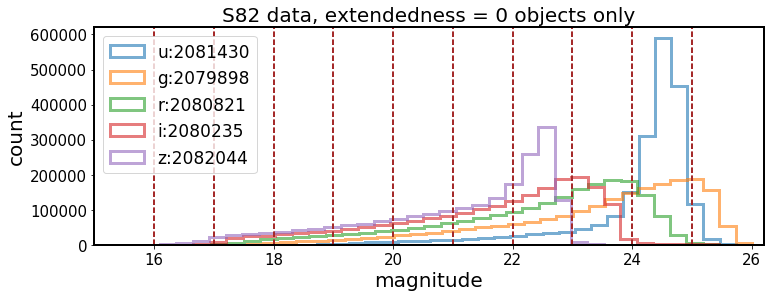

In [73]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(12,4))

# select only extendedness = 0 : 

mask_e = data['extendedness'].data.data == 0 

count = 0 
suffix = '_all'
for f in 'ugriz':
    mask_mag = (data[f+'psfMean'+suffix].data.data > 15 ) *\
               (data[f+'psfMean'+suffix].data.data < 26 ) 
    m = mask_e * mask_mag
    count = np.sum(m)
    ax.hist(data[f+'psfMean'+suffix].data.data[m], bins=40, 
            histtype='step', label=f+':'+str(count), lw=3, alpha=0.6)
for magMin in range(16,26):
    magMax = magMin + 1 
    ax.axvline(magMin, ls='--', color='brown', lw=2)
ax.set_xlim(15,26.2)
ax.set_title('S82 data, extendedness = 0 objects only')
ax.set_xlabel('magnitude')
ax.set_ylabel('count')
plt.legend(loc='upper left', fontsize=17)

plt.savefig( outDir+'Fig_1_unresolved_hist_'+suffix+'.png', bbox_inches='tight')

### Four-panel color-color 

In [22]:
# Not needed for now - I don't see any specific use of that plot .... 

### $\chi^{2}$ - $\chi^{2}$ plane in u,g,r,i : choice of g 

This shows all data for point-like objects, allowing us to select variability by cutting in $\chi^2$ space ... 

4< mag <23


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: divide by zero encountered in log10


Saving as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_finding_QSO/2017-06-27/Fig_2_chi2_ugri_e-0_mag_4-23_all.png


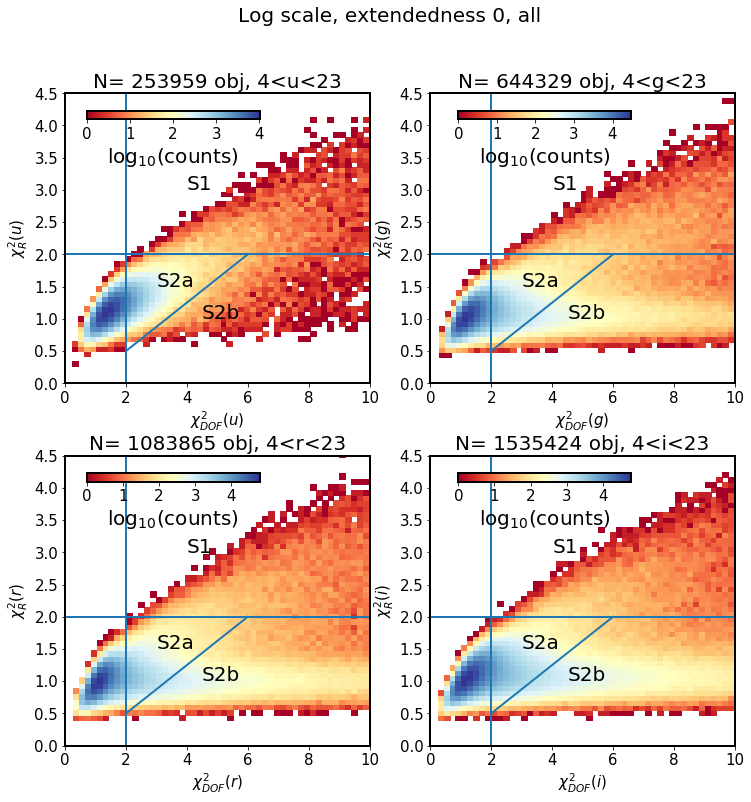

In [74]:
%matplotlib inline 

filters = 'ugri'



step_magnitudes = False
if step_magnitudes : 
    magMinArr = np.arange(16,25)
    magMaxArr = magMinArr + 1 
else:
    magMinArr = [4]
    magMaxArr = [23]

e = 0
suffix = '_all'

for magMin, magMax in zip(magMinArr, magMaxArr):
    print('%d< mag <%d'%(magMin, magMax))

    # initialize the figure for a given 
    # extendedness, suffix, and mag range 
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    colorbar_axs  = {}
    colorbar_axs[0] =   fig.add_axes([0.15, 0.85, 0.2, 0.01]) 
    colorbar_axs[1] =   fig.add_axes([0.58, 0.85, 0.2, 0.01])
    colorbar_axs[2] =   fig.add_axes([0.15, 0.43, 0.2, 0.01])
    colorbar_axs[3] =   fig.add_axes([0.58, 0.43, 0.2, 0.01])

    ax = np.ravel(axs)

    for j in range(len(filters)):
        f = filters[j]
        chi2dof = data[f+'chi2DOF'+suffix].data.data
        chi2R = data[f+'chi2R'+suffix].data.data
        m1 = (~np.isnan(chi2dof))&(~np.isnan(chi2R))
        m2 = (chi2dof < 10) & (chi2R < 10 )
        m3 =          data[f+'psfMean'+suffix].data.data < magMax 
        m4 = magMin < data[f+'psfMean'+suffix].data.data 
        m5 = data['extendedness'].data.data == e
        m = m1 * m2 * m3 * m4 * m5 

        nObj = len(chi2dof[m])

        if nObj < 500 : 
            ax[j].scatter(chi2dof[m],chi2R[m])
        else : 
            stats = binned_statistic_2d(x=chi2dof[m], y=chi2R[m], 
                                    values=chi2dof[m], statistic='count', bins=50)
            z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
            z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
            z_reduce  =  z_sigma
            z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
            z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
            z_rot_flip = np.flipud(z_rot)
            z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

            # Plot 2D histogram using pcolor
            image = ax[j].pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                                     cmap=plt.cm.get_cmap('RdYlBu'))

        ax[j].set_xlabel(r'$\chi^{2}_{DOF}('+f+')$', fontsize=15)
        ax[j].set_ylabel(r'$\chi^{2}_{R}('+f+')$', fontsize=15)
        ax[j].set_title('N= %d obj, %d<%s<%d'%( nObj, magMin, f, magMax))
        ax[j].tick_params(axis='both', which='major', labelsize=15) 

        # plot limits of variability regions ... 
        thickness = 2 
        ax[j].axvline(2, lw=thickness)
        ax[j].axhline(2, lw=thickness)
        x = np.linspace(2,6,100)
        ax[j].plot(x, 0.375 * x - 0.25, lw=thickness)

        # Set limits , add region labels 
        ax[j].set_xlim(0,10)
        ax[j].set_ylim(0,4.5)

        ax[j].text(4,3,'S1', fontsize=20)
        ax[j].text(3,1.5,'S2a', fontsize=20)
        ax[j].text(4.5,1,'S2b', fontsize=20)
        # Make a colorbar 
        colorbar = fig.colorbar(image,  cax=colorbar_axs[j], orientation='horizontal',
                               label=r'$\log_{10}{(\mathrm{counts})}$')
        tick_locator = ticker.MaxNLocator(nbins=5)
        colorbar.locator = tick_locator
        colorbar.update_ticks()
     
    fig.subplots_adjust(hspace=0.25)
    suptitle =  'Log scale, extendedness '+str(e) +', '+suffix[1:]
    fig.suptitle(suptitle, fontsize=20)
    figname = outDir+'Fig_2_chi2_ugri_e-'+str(e)+'_mag_'+str(magMin)+'-'+str(magMax)+suffix+'.png'
    print('Saving as %s'%figname)
    plt.savefig(figname)

### u-g vs g-r : S1 in color space (Sesar+2007 Fig.3)

Given the choice of variability selection above, we show the impact of $\chi^{2}$ - selection on u-g vs g-r space . Top panel : total counts,  middle panel : variable count,  bottom panel : ratio 

In [30]:
#data.colnames

In [75]:
%matplotlib inline


def plot_ug_gr_panels(data=None, var='s1', gmin=3, gmax=23 ):
    ''' A convenience function to plot u-g vs g-r three-panel plot, 
    analoguous to Sesar+2007 Fig.3. The top panel is total count,
    the middle panel the variable count, the bottom panel the ratio
    of variable to total count. 

    Input: 
        ------
        data :  an AstroPy Table that contains columns with  {u,g,r}+'psfMean_all' , 
        'g'+{chi2DOF, chi2R}+'_all', i.e. all data to plot . Default : None

        var : a string that defines how we should define the variable sample
        in the middle panel 
        Possible choices include  's1', 's2a', 's2b' : all these
        denote different regions in chi2R - chi2DOF space . Default : 's1' : the 
        highly-variable objects 

        gmin, gmax : floats, defining the minimum and maximum g-magnitude for objects 
        on the plot. Default : gmin= 4 , gmax = 23 
    '''
    suffix = '_all'
    chi2R = data['gchi2R'+suffix].data.data
    chi2DOF = data['gchi2DOF'+suffix].data.data
    extendedness = data['extendedness'].data.data
    u = data['upsfMean'+suffix].data.data
    g = data['gpsfMean'+suffix].data.data
    r = data['rpsfMean'+suffix].data.data

    # set magnitude range ... 
    print('%d< g-mag <%d'%(gmin, gmax))

    # set extendedness : only star-like objects 
    mask_ext = extendedness == 0

    # set color range boundaries (even though we are not selecting by color here,
    # remove the objects with ug - gr colors outside of the plot boundaries, so
    # that the histogram will look nice )
    mask_g = (gmin < g) *(g < gmax)
    mask_ug =  (-0.5 < (u-g)) * ((u-g) < 2.8)      
    mask_gr =  (-0.5 < (g-r)) * ((g-r) < 1.6) 
    mask_color = mask_ug * mask_gr * mask_g
    # we are not color-cutting, so 
    # just include the mag cut ... 
    color_title =  str(gmin)+'< g <'+str(gmax)

    # Select variable sample .. 
    var  = 's1'
    bounds = 2.5 

    # define location of colorbar 
    cbar_x0 = 0.2
    cbar_y0 = [0.33, 0.6 , 0.86]

    cbar_dx = 0.4
    cbar_dy = 0.01 

    # add variability  cuts ...
    # separation line : ax + b 
    a = 0.375
    a_str = '{0:f}'.format(a).rstrip('0')
    b = -0.25
    b_str = '{0:+f}'.format(b).rstrip('0')

    if var is 's1' : 
        mask_var = (chi2R > bounds ) * ( chi2DOF > bounds )
        var_title = str(bounds)+ r'$< \chi^{2}_{DOF,R}(g)$'

    if var is 's2a':  
        mask_var = (chi2R < bounds ) * ( chi2DOF > bounds )\
                * (chi2R >a * chi2DOF +b)
        var_title = str(bounds)+ r'$< \chi^{2}_{DOF}(g),$ ' \
                    +r'$ \chi^{2}_{R}(g)<$'+str(bounds)+', '\
                    +r'$ \chi^{2}_{R}(g)>$'+a_str\
                    +r'$ \chi^{2}_{DOF}(g)$'+b_str

    if var is 's2b' : 
        mask_var = (chi2R < bounds ) * ( chi2DOF > bounds ) \
                * (chi2R <a * chi2DOF +b)
        var_title = str(bounds)+ r'$< \chi^{2}_{DOF}(g),$ ' \
                    +r'$ \chi^{2}_{R}(g)<$'+str(bounds)+', '\
                    +r'$ \chi^{2}_{R}(g)<$'+a_str\
                    +r'$ \chi^{2}_{DOF}(g)$'+b_str


    suptitle = 'unresolved, ' + color_title+'\n' +\
                    var + ': '+ var_title

    # Define the region for plotting ... 
    fig, ax = plt.subplots(3,1, figsize=(5.5,18))
    cmap = 'jet' # plt.cm.get_cmap('RdYlBu') 

    ############################
    # TOP PANEL :  TOTAL COUNT #
    ############################
    # combine color and extendedness 
    m = mask_color * mask_ext 
    nObj = len(u[m])
    ug = u[m]-g[m]
    gr = g[m]-r[m]
    stats = binned_statistic_2d(x=ug, y=gr, values=ug, 
                                statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] = 0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

    # Plot 2D histogram using pcolor
    image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap=cmap)
    ax[0].set_title('Lin scale, total count %d' % nObj)
    ax[0].tick_params(axis='both', which='major', labelsize=15) 

    colorbar_ax = fig.add_axes([cbar_x0, cbar_y0[2], cbar_dx, cbar_dy])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

    ####################################
    # MIDDLE PANEL :  VARIABLE COUNT   #
    ####################################

    # combine color, extendedness and variability
    m = mask_color * mask_ext * mask_var
    nObj = len(u[m])
    ug = u[m]-g[m]
    gr = g[m]-r[m]
    # Calculate the count of variable sources...
    stats = binned_statistic_2d(x=ug, y=gr, values=ug, 
                                statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    # replace all nan's by 0 ...
    z_sigma[np.isnan(z_sigma)] =0 
    z_reduce  =  z_sigma 
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

    # Plot 2D histogram using pcolor
    image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var, cmap=cmap)
    ax[1].set_title('Lin scale, variable count %d  '%nObj)
    ax[1].tick_params(axis='both', which='major', labelsize=15) 
    colorbar_ax = fig.add_axes([cbar_x0, cbar_y0[1], cbar_dx, cbar_dy])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

    ###################################################
    # BOTTOM PANEL :  VARIABLE COUNT / TOTAL COUNT    #
    ###################################################

    z_masked_ratio = z_masked_var / z_masked
    # Mask pixels with a value of zero

    # Plot 2D histogram using pcolor
    Z =  np.log10(z_masked_ratio)
    image = ax[2].pcolormesh(x_edges,y_edges, Z, cmap=cmap, vmax = 0)
    ax[2].set_title('Log scale,' + r'$n_{VAR}$'+'/'+ r'$n_{TOT}$' )
    ax[2].tick_params(axis='both', which='major', labelsize=15) 

    colorbar_ax = fig.add_axes([cbar_x0, cbar_y0[0], cbar_dx, cbar_dy])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

    #plt.tight_layout()
    # Saving the colorbar from being messed by the tight_layout()
    # http://matplotlib.org/users/tight_layout_guide.html

    Xlabel = 'u-g'
    Ylabel = 'g-r'

    fig.text(0., 0.5, Ylabel, ha='center', va='center', rotation='vertical', fontsize=25)
    fig.text(0.5, 0.1, Xlabel, ha='center', va='center', fontsize=25)
    fig.suptitle(suptitle, fontsize=18 )
    fig.subplots_adjust(wspace=0.2)

    fname = outDir+'Fig_3_'+var+'_g_'+ str(gmin)+'-'+str(gmax)+'.png'
    plt.savefig(fname,bbox_inches='tight')
    print('Saved as %s '%fname)


3< g-mag <23


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:154: RuntimeWarning: divide by zero encountered in log10


Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_finding_QSO/2017-06-27/Fig_3_s1_g_3-23.png 


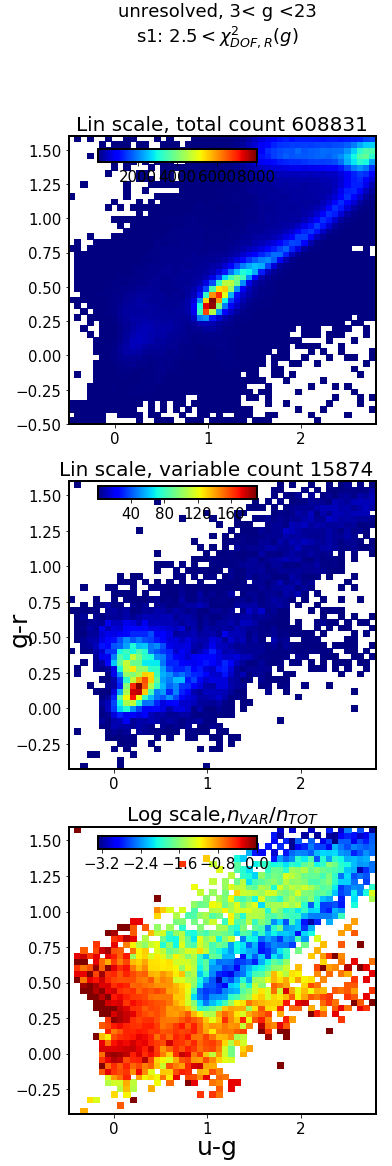

In [76]:
plot_ug_gr_panels(data)

'unresolved, 3< g <23\ns1: 2$< \\chi^{2}_{DOF,R}(g)$'

### $\chi^{2}$ - $\chi^{2}$ plane and color cuts 

We plot in the $\chi^{2}_{DOF} -\chi^{2}_{R}$ plane :

a) total counts,  

b) color-selected subsample (using conservative  boundaries 
  
  -0.5 < u-g < 0.5
  
  0 < g-r < 0.5 

but anything else could be used as well) , and 

c) ratio  of b to a 

In [92]:
def plot_2d_histogram(figure, axis, colorbar_ax,  x,y, values, 
                      statistic='count', bins=50, cmap ='jet', 
                      xlabel = 'u-g', ylabel = 'g-r', logscale = False, 
                      title_count = 'total', gmin=4, gmax=23 ):
    
    stats = binned_statistic_2d(x=x, y=y,  values=values, 
                                statistic=statistic, bins=bins)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

    # Plot 2D histogram using pcolor
    if logscale : 
        image = axis.pcolormesh(x_edges,y_edges,np.log10(z_masked), cmap=cmap)
    else : 
        image = axis.pcolormesh(x_edges,y_edges,z_masked, cmap=cmap)
    
    nObj = len(x)
    
    if logscale : 
        axis.set_title('Log scale, N %s %d obj'%(title_count, nObj))
    else : 
        axis.set_title('Lin scale, N %s %d obj'%(title_count, nObj))
    
    axis.tick_params(axis='both', which='major', labelsize=15) 

    # add a colorbar 
    colorbar = figure.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    
    return  z_masked

In [93]:
%matplotlib inline 

# a) left panel, plot all objects in that cut 
# b) middle panel : those that satisfy  ug, gr color cut 
# c) right panel ratio b / a 

def plot_chi2_colors(data=None, gmin=4, gmax=23, ug_lims=[-0.5,0.5], gr_lims=[0, 0.5 ]):
    ''' A convenience function  to plot three chi2-chi2 plots.  Left column:
    total counts, middle column : counts within color-selected region,
    Right column : ratio of color-selected to all counts. 

    '''
    suffix = '_all'
    chi2R = data['gchi2R'+suffix].data.data
    chi2DOF = data['gchi2DOF'+suffix].data.data
    extendedness = data['extendedness'].data.data
    u = data['upsfMean'+suffix].data.data
    g = data['gpsfMean'+suffix].data.data
    r = data['rpsfMean'+suffix].data.data
    
    ug_min, ug_max = ug_lims[0], ug_lims[1]
    gr_min, gr_max = gr_lims[0],gr_lims[1]

    # set magnitude range ... 
    print('%d< g-mag <%d'%(gmin, gmax))

    # set extendedness : only star-like objects 
    mask_ext = extendedness == 0

    # set color range boundaries (even though we are not selecting by color here,
    # remove the objects with ug - gr colors outside of the plot boundaries, so
    # that the histogram will look nice )
    mask_g = (gmin < g) *(g < gmax)
    mask_ug =  ( ug_min < (u-g)) * ((u-g) < ug_max)      
    mask_gr =  (gr_min < (g-r)) * ((g-r) < gr_max) 
    mask_color = mask_ug * mask_gr 

    # we are not color-cutting, so 
    # just include the mag cut ... 
    color_title = str(ug_min)+' <u-g< '+str(ug_max)+', ' \
                  +str(gr_min)+' <g-r< '+str(gr_max)+', ' \
                  +str(gmin)+'<g<'+str(gmax)

    # remove chi2 outliers ...
    mask_chi2_nans = (~np.isnan(chi2DOF))&(~np.isnan(chi2R))
    mask_outliers = (chi2DOF < 10) & (chi2R < 10 )
    mask_chi2 = mask_chi2_nans * mask_outliers

    # location of colorbar ... 
    x0_values  = [0.15, 0.43, 0.70]
    y0_values  = [0.83] 

    # colorbar settings...
    cbar_dx = 0.17
    cbar_dy = 0.03 

    # colormap
    cmap = plt.cm.get_cmap('RdYlBu')

    # define plot range 
    fig, ax = plt.subplots(1,3, figsize = (18, 6 ))
    
    ############################
    # LEFT PANEL :  TOTAL COUNT #
    ############################
    col = 0 
    m = mask_ext * mask_g * mask_chi2
    colorbar_ax = fig.add_axes([x0_values[col], y0_values[row], cbar_dx, cbar_dy])  

    z_total = plot_2d_histogram(figure = fig, axis = ax[col], 
                                  colorbar_ax=colorbar_ax,  x = chi2DOF[m],
                                  y = chi2R[m], values=chi2DOF[m], statistic='count', 
                                  bins=50, cmap =cmap, xlabel = None, 
                                  ylabel = None, logscale = True, title_count = 'total', 
                                   gmin=gmin, gmax=gmax )
    ######################################
    # MIDDLE PANEL :  WITHIN COLOR COUNT #
    ######################################
    col = 1 
    m = mask_ext * mask_g * mask_chi2 * mask_color
    colorbar_ax = fig.add_axes([x0_values[col], y0_values[row], 
                                cbar_dx, cbar_dy])  

    z_color = plot_2d_histogram(figure = fig, axis = ax[col], 
                                colorbar_ax=colorbar_ax,  x = chi2DOF[m],
                                y = chi2R[m], values=chi2DOF[m], statistic='count', 
                                bins=50, cmap =cmap, xlabel = None, 
                                ylabel = None, logscale = True, title_count = 'color', 
                                gmin=gmin, gmax=gmax )
    #############################
    # RIGHT PANEL :  RATIO      #
    #############################
    col = 2 

    z_ratio = z_color / z_total 
    stats = binned_statistic_2d(x=chi2DOF[m], y=chi2R[m],  values=chi2R[m], 
                                statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    image = ax[col].pcolormesh(x_edges,y_edges, np.log10(z_ratio), cmap=cmap, vmax = 0)
    ax[col].set_title('Log scale, n_col / n_tot')
    ax[col].tick_params(axis='both', which='major', labelsize=15) 

    colorbar_ax = fig.add_axes([x0_values[col], y0_values[row], cbar_dx, cbar_dy])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()

    # add plot labels 
    f = 'g'
    Xlabel = r'$\chi^{2}_{DOF}('+f+')$'
    Ylabel = r'$\chi^{2}_{R}('+f+')$'
    fig.text(0.5, 0.03, Xlabel, ha='center', va='center', fontsize=25)
    fig.text(0.08, 0.5, Ylabel, ha='center', va='center', 
             rotation='vertical', fontsize=25)
    fig.suptitle('e = '+str(e)+', '+color_title, fontsize=20)

    title = 'Fig_4_chi2_panels_'+'_g-'+str(gmin)+'-'+str(gmax)+'.png' 
    plt.savefig(outDir+title)
    print('Saved as %s'%(outDir+title))


            
            

4< g-mag <22


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:97: RuntimeWarning: divide by zero encountered in log10


Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_finding_QSO/2017-06-27/Fig_4_chi2_panels__g-4-22.png


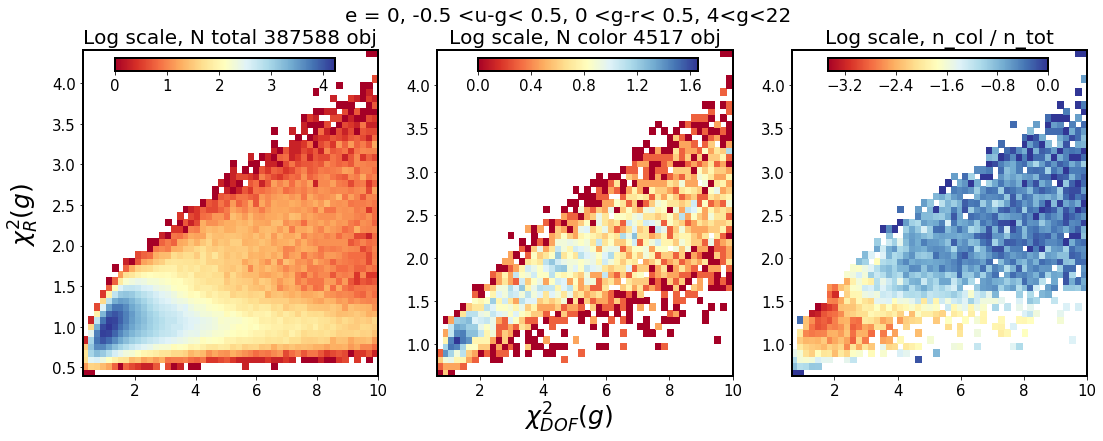

In [96]:
plot_chi2_colors(data, gmin=4, gmax=22)